In [1]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [3]:
# Set this to True to include sentiment features, False to exclude them
INCLUDE_SENTIMENT = 'FALSE'

In [4]:
# Step 1: Load preprocessed data
def load_preprocessed_data(filepath):
    """
    Load the preprocessed dataset
    """
    df = pd.read_csv(filepath)
    print(f"Preprocessed data loaded with shape: {df.shape}")
    return df

In [5]:
def get_mxbai_embeddings(texts, batch_size=8, max_length=256):
    model_name = "mixedbread-ai/mxbai-embed-large-v1"

    # Initialize tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Put model in evaluation mode
    model.eval()

    # Process in batches
    embeddings = []

    # Process data in batches with progress bar
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i + batch_size]

        # Tokenize
        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        ).to(device)

        # Generate embeddings
        with torch.no_grad():
            outputs = model(**inputs)

        # Use [CLS] token embedding (first token of last hidden state)
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(batch_embeddings)

    # Concatenate all batch embeddings
    all_embeddings = np.vstack(embeddings)

    return all_embeddings


In [6]:
def extract_sentiment_features(texts):
    sentiment_features = []

    for text in tqdm(texts):
        try:
            # Create TextBlob object
            blob = TextBlob(str(text))

            # Get sentiment properties
            polarity = blob.sentiment.polarity
            subjectivity = blob.sentiment.subjectivity

            # Calculate additional features
            word_count = len(text.split())
            char_count = len(text)
            avg_word_length = char_count / max(word_count, 1)

            # Count special characters
            exclamations = text.count('!')
            questions = text.count('?')

            # Add to list
            sentiment_features.append({
                'polarity': polarity,
                'subjectivity': subjectivity,
                'word_count': word_count,
                'char_count': char_count,
                'avg_word_length': avg_word_length,
                'exclamations': exclamations,
                'questions': questions
            })
        except:
            # Handle errors
            sentiment_features.append({
                'polarity': 0.0,
                'subjectivity': 0.0,
                'word_count': 0,
                'char_count': 0,
                'avg_word_length': 0,
                'exclamations': 0,
                'questions': 0
            })

    return pd.DataFrame(sentiment_features)

In [7]:
def visualize_embeddings(embeddings, labels, method='pca'):
    """
    Visualize high-dimensional embeddings using PCA or t-SNE
    """
    print(f"Visualizing embeddings using {method.upper()}...")

    # Convert class numbers to meaningful names
    class_names = {0: 'Hate Speech', 1: 'Offensive', 2: 'Neither'}
    label_names = [class_names[label] for label in labels]

    # Apply dimensionality reduction
    if method.lower() == 'pca':
        reducer = PCA(n_components=2)
    else:  # t-SNE
        reducer = TSNE(n_components=2, random_state=42)

    # Use a subset for visualization to avoid overcrowding
    max_samples = min(5000, len(embeddings))
    if len(embeddings) > max_samples:
        indices = np.random.choice(len(embeddings), max_samples, replace=False)
        vis_embeddings = embeddings[indices]
        vis_labels = [label_names[i] for i in indices]
    else:
        vis_embeddings = embeddings
        vis_labels = label_names

    # Reduce dimensions
    reduced_embeddings = reducer.fit_transform(vis_embeddings)

    # Create DataFrame for plotting
    plot_df = pd.DataFrame({
        'x': reduced_embeddings[:, 0],
        'y': reduced_embeddings[:, 1],
        'class': vis_labels
    })

    # Plot
    plt.figure(figsize=(12, 8))
    # Define a custom color palette
    color_map = {'Hate Speech': '#D55E00', 'Offensive': '#0072B2', 'Neither': '#009E73'}

    sns.scatterplot(x='x', y='y', hue='class', data=plot_df, palette=color_map)

    plt.title(f'Embedding Visualization using {method.upper()}', fontsize=15)
    plt.xlabel(f'{method.upper()} Component 1')
    plt.ylabel(f'{method.upper()} Component 2')
    plt.legend(title='Class')
    plt.tight_layout()
    plt.savefig(f"/content/drive/My Drive/SMM/Images/Feature_extraction/embeddings_{method.lower()}.png", dpi=300)
    plt.show()
    plt.close()

In [8]:
def visualize_sentiment_features(sentiment_df, labels):
    """
    Visualize sentiment features
    """
    print("Visualizing sentiment features...")

    # Convert class numbers to meaningful names
    class_names = {0: 'Hate Speech', 1: 'Offensive', 2: 'Neither'}
    label_names = [class_names[label] for label in labels]

    # Create a DataFrame with class labels
    vis_df = sentiment_df.copy()
    vis_df['class'] = label_names

    # Plot distributions of sentiment features by class
    sentiment_cols = ['polarity', 'subjectivity']

    for col in sentiment_cols:
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='class', y=col, data=vis_df)
        plt.title(f'Distribution of {col} by Class', fontsize=15)
        plt.tight_layout()
        plt.savefig(f"/content/drive/My Drive/SMM/Images/Feature_extraction/{col}_by_class.png", dpi=300)
        plt.show()
        plt.close()

    # Plot scatter plot of polarity vs subjectivity
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='polarity', y='subjectivity', hue='class', data=vis_df, alpha=0.7)
    plt.title('Polarity vs Subjectivity by Class', fontsize=15)
    plt.tight_layout()
    plt.savefig(f"/content/drive/My Drive/SMM/Images/Feature_extraction/polarity_vs_subjectivity.png", dpi=300)
    plt.show()
    plt.close()

    # Plot distributions of text statistics by class
    stat_cols = ['word_count', 'avg_word_length', 'exclamations', 'questions']

    for col in stat_cols:
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='class', y=col, data=vis_df)
        plt.title(f'Distribution of {col} by Class', fontsize=15)
        plt.tight_layout()
        plt.savefig(f"/content/drive/My Drive/SMM/Images/Feature_extraction/{col}_by_class.png", dpi=300)
        plt.show()
        plt.close()

In [9]:
def visualize_feature_importance(feature_df, class_col='class'):
    """
    Visualize feature correlations with target
    """
    print("Analyzing feature correlations...")

    # Exclude the class column
    features = feature_df.drop(columns=[class_col])

    # Get correlation with target for non-embedding features
    non_embed_cols = [col for col in features.columns if not col.startswith('embed_')]

    if non_embed_cols:
        corr_df = pd.DataFrame({
            'Feature': non_embed_cols,
            'Correlation': [features[col].corr(feature_df[class_col]) for col in non_embed_cols]
        })

        corr_df = corr_df.sort_values('Correlation', key=abs, ascending=False)

        plt.figure(figsize=(10, 8))
        sns.barplot(x='Correlation', y='Feature', data=corr_df)
        plt.title('Feature Correlation with Target Class', fontsize=15)
        plt.tight_layout()
        plt.savefig(f"/content/drive/My Drive/SMM/Images/Feature_extraction/feature_correlation.png", dpi=300)
        plt.show()
        plt.close()

In [10]:
# Main function
def main():
    # Step 1: Load preprocessed data
    filepath = '/content/drive/My Drive/SMM/csv_files/preprocessed_data.csv'
    df = load_preprocessed_data(filepath)

   # Use the processed_text column for embeddings
    text_column = 'processed_text'

    # Get text data
    texts = df[text_column].fillna("").tolist()

    # Generate embeddings
    embeddings = get_mxbai_embeddings(texts)

    # Visualize embeddings (this might take some time for large datasets)
    visualize_embeddings(embeddings, df['class'].values, method='pca')

    # Convert embeddings to DataFrame
    embedding_df = pd.DataFrame(
        embeddings,
        columns=[f'embed_{i}' for i in range(embeddings.shape[1])]
    )

    # Create the final feature DataFrame
    if INCLUDE_SENTIMENT:
        # With sentiment features
        sentiment_df = extract_sentiment_features(texts)

        # Visualize sentiment features
        visualize_sentiment_features(sentiment_df, df['class'].values)

        feature_df = pd.concat([embedding_df, sentiment_df], axis=1)
        output_file = "/content/drive/My Drive/SMM/csv_files/combined_features_with_sentiment.csv"
    else:
        # Without sentiment features - just use embeddings
        feature_df = embedding_df
        output_file = "/content/drive/My Drive/SMM/csv_files/combined_features_embeddings_only.csv"

    # Add class labels
    feature_df['class'] = df['class']

    # Visualize feature importance
    if INCLUDE_SENTIMENT:
        visualize_feature_importance(feature_df)

    # Save features
    feature_df.to_csv(output_file, index=False)
    print(f"Features saved to {output_file}")
    print(f"Feature set shape: {feature_df.shape}")

    # Show feature names to verify
    feature_types = {
        'Embedding features': [col for col in feature_df.columns if col.startswith('embed_')],
        'Sentiment features': [col for col in feature_df.columns if not col.startswith('embed_') and col != 'class'],
        'Target': ['class']
    }

    for feature_type, features in feature_types.items():
        print(f"\n{feature_type} ({len(features)}): {', '.join(features[:5])}{'...' if len(features) > 5 else ''}")

    print("\nVisualizations saved to current directory")

Preprocessed data loaded with shape: (24783, 12)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

100%|██████████| 3098/3098 [2:19:35<00:00,  2.70s/it]


Visualizing embeddings using PCA...


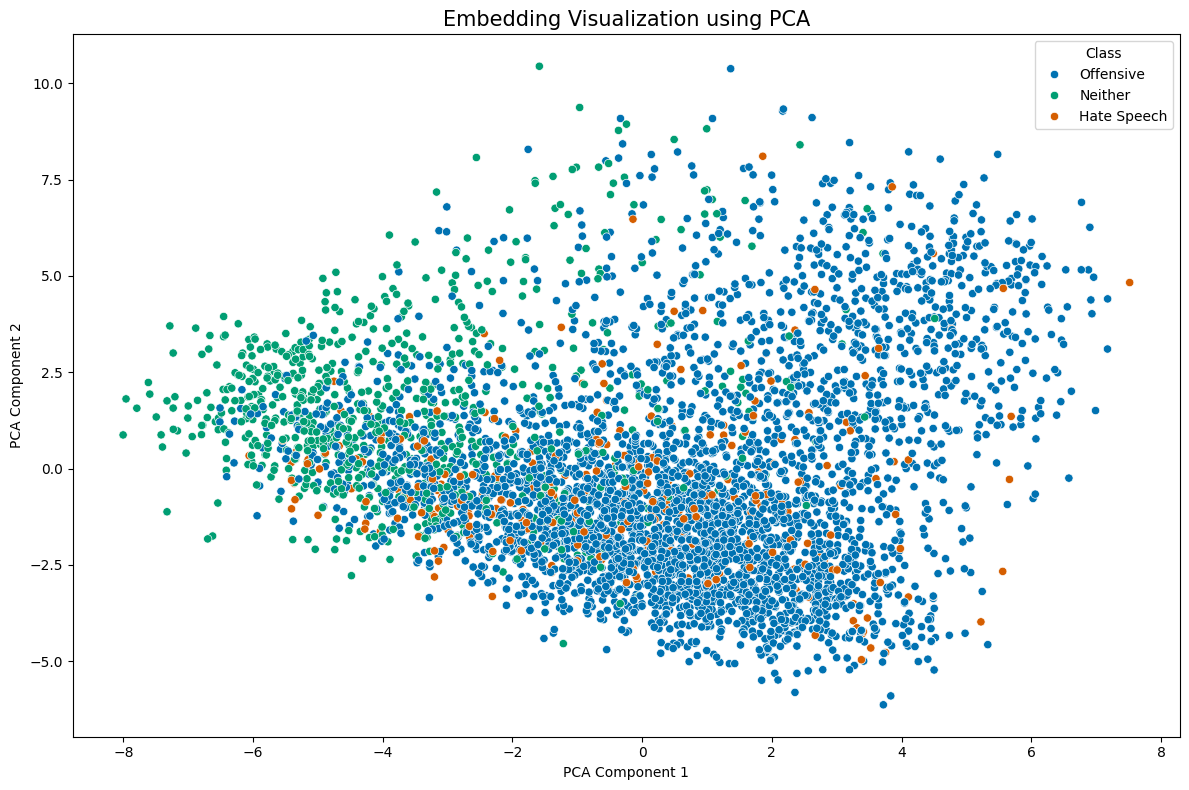

100%|██████████| 24783/24783 [00:05<00:00, 4160.66it/s]


Visualizing sentiment features...


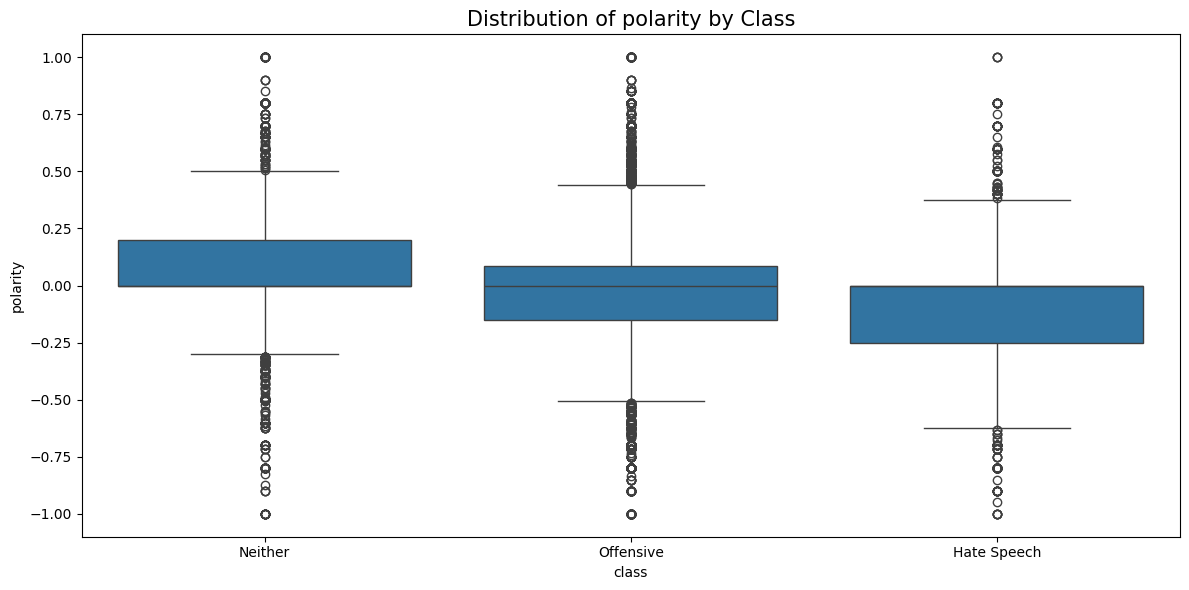

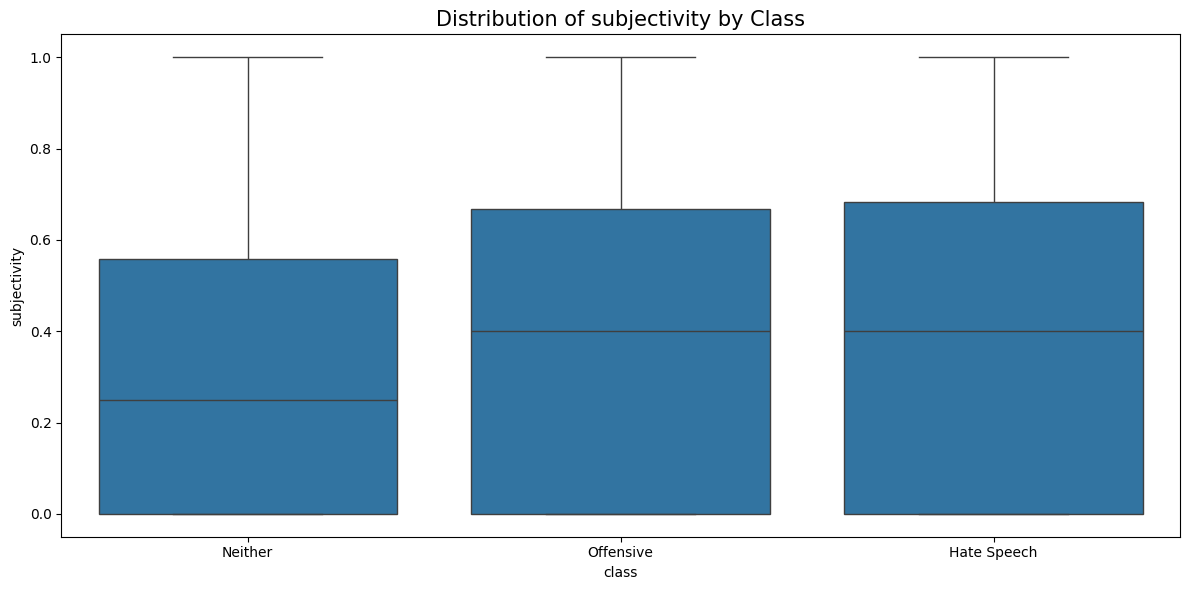

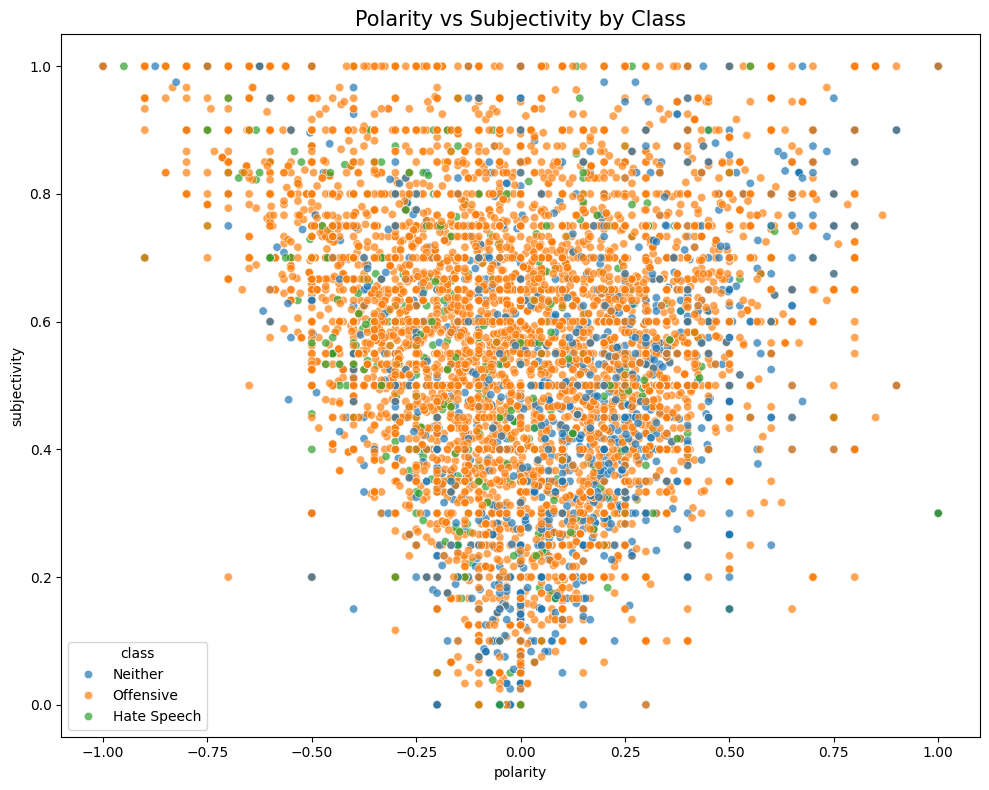

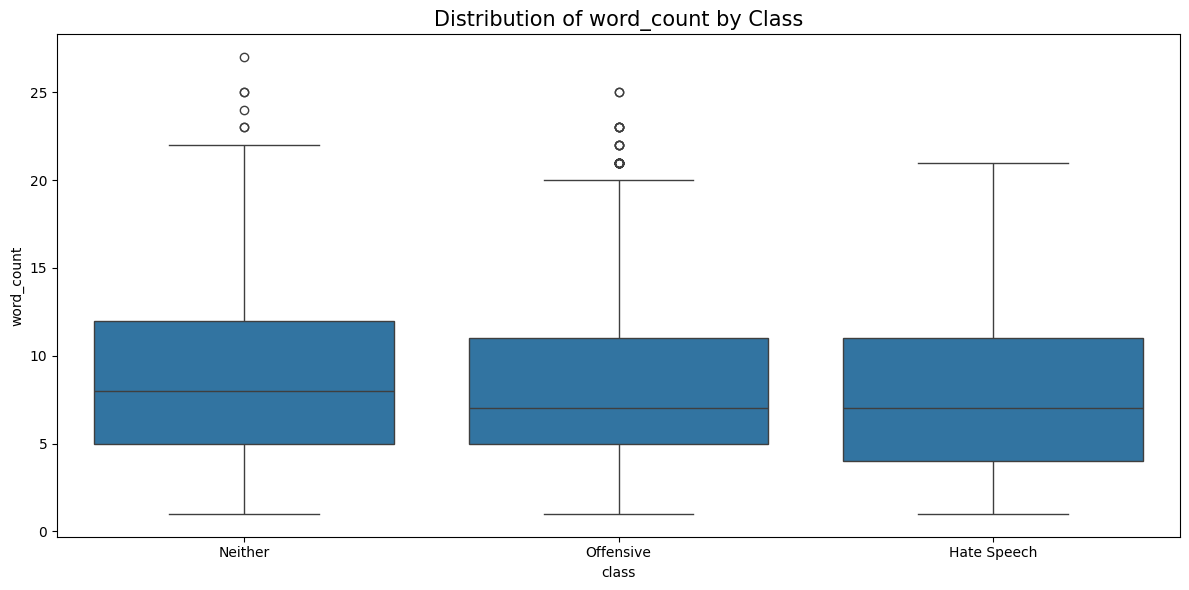

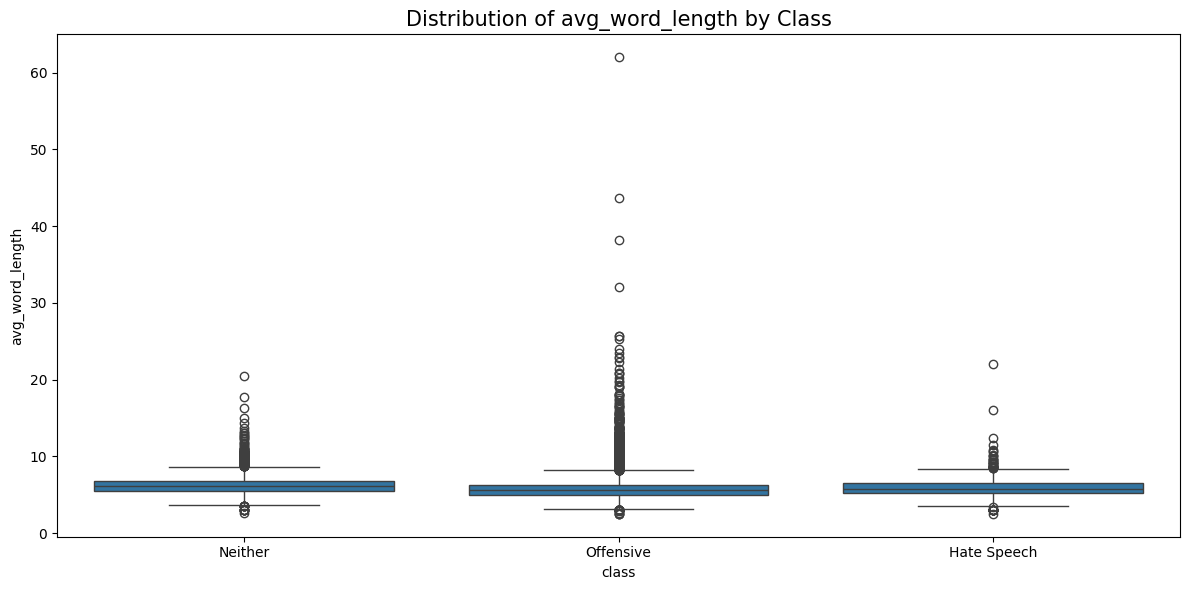

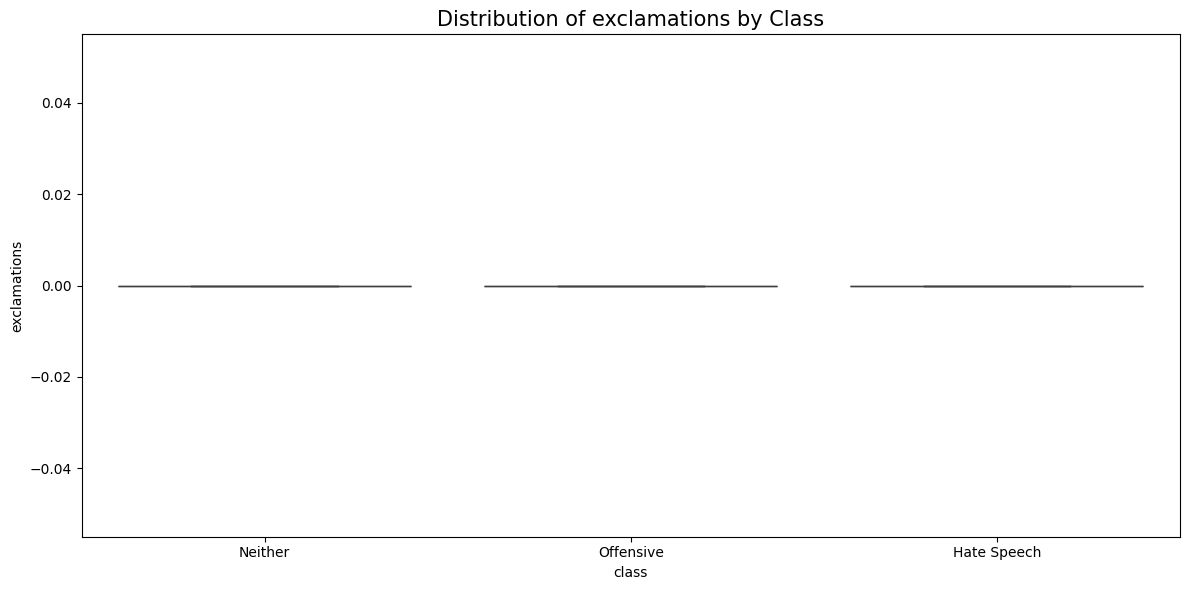

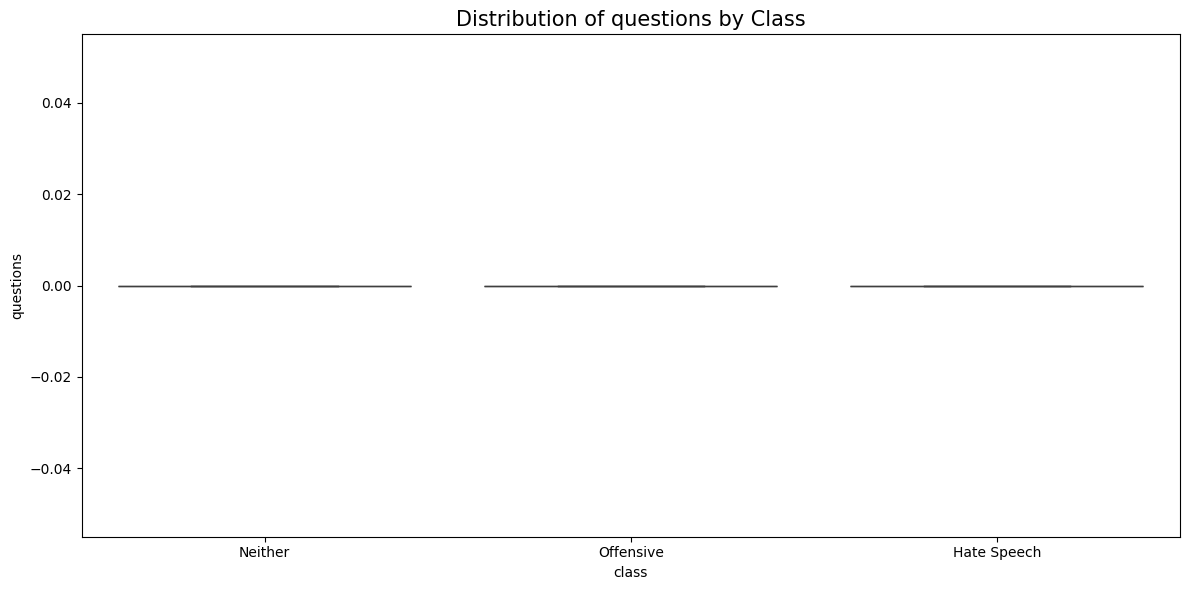

Analyzing feature correlations...


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


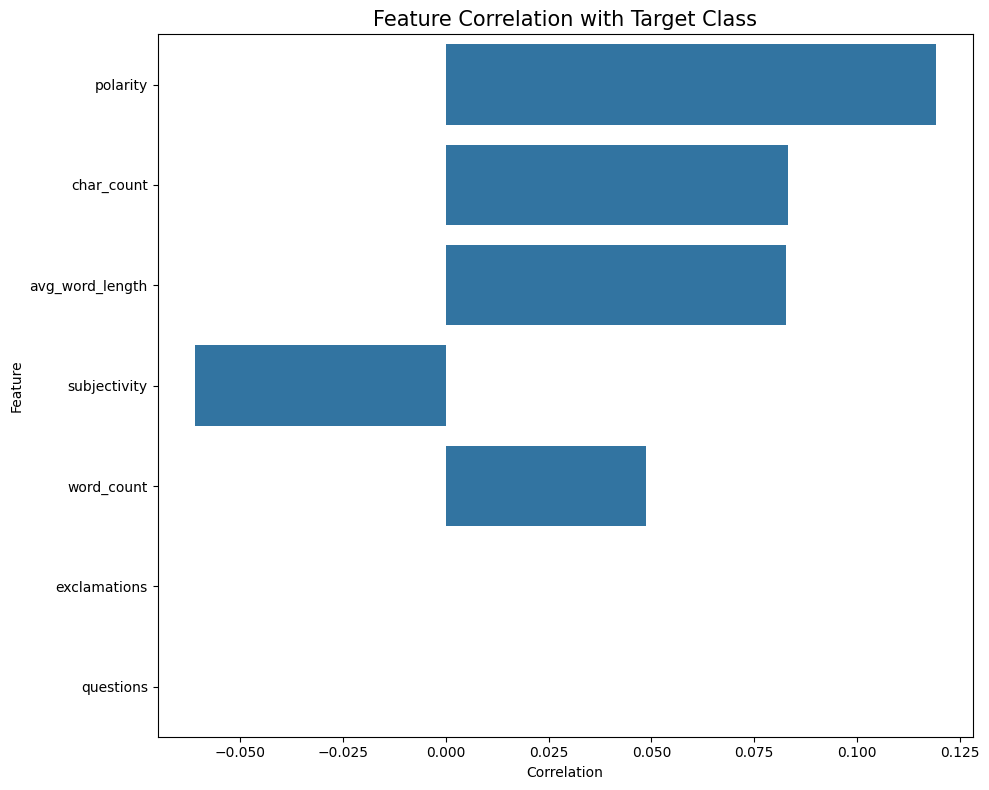

Features saved to /content/drive/My Drive/SMM/csv_files/combined_features_with_sentiment.csv
Feature set shape: (24783, 1032)

Embedding features (1024): embed_0, embed_1, embed_2, embed_3, embed_4...

Sentiment features (7): polarity, subjectivity, word_count, char_count, avg_word_length...

Target (1): class

Visualizations saved to current directory


In [11]:
if __name__ == "__main__":
    main()